In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.2877 - loss: 3.1185 - val_accuracy: 0.0000e+00 - val_loss: 1.8398
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3338 - loss: 1.3543 - val_accuracy: 0.0000e+00 - val_loss: 1.6914
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3599 - loss: 1.3496 - val_accuracy: 0.0000e+00 - val_loss: 1.7727
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3364 - loss: 1.3478 - val_accuracy: 0.0000e+00 - val_loss: 1.8860
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3609 - loss: 1.3347 - val_accuracy: 0.0000e+00 - val_loss: 1.9036


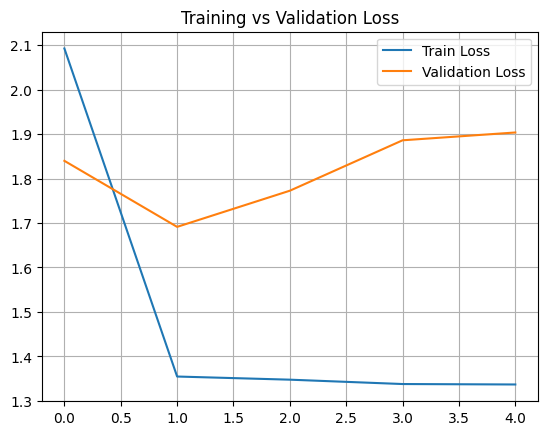

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.00      0.00      0.00       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.00      0.00      0.00       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.00      0.00      0.00       233
                          Normal Person ECG Images (284x12=3408)       0.31      1.00      0.47       284

                                                        accuracy                           0.31       928
                                                       macro avg       0.08      0.25      0.12       928
                                                    weighted avg       0.09      0.31      0.14       928


Confusion Matrix:
[[  0   0   0 239]
 [  0   0   0 172]
 [  0   0   0 233]
 [  0   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# SETTINGS
IMG_SIZE = 64
BASE_PATH = '/kaggle/input/ecg-analysis/ECG_DATA/'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

# Load images
def load_images(folder_path):
    images, labels = [], []
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir): continue
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img.flatten())
            labels.append(class_name)
    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_images(TRAIN_PATH)
X_test, y_test = load_images(TEST_PATH)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))

# Model definition
model = Sequential([
    Dense(512, activation='relu', input_shape=(IMG_SIZE * IMG_SIZE,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32,
                    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
                    verbose=1)

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
